# Function

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn, optim
from torchvision import models, transforms

import os
import cv2
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image, ImageFilter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# Data Setup

In [ ]:
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# transform_train = transforms.Compose([
#     transforms.Resize(224),
#     transforms.RandomRotation(15),
#     transforms.RandomHorizontalFlip(),
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
#     transforms.ToTensor(),
#     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
# ])


transform_test = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

batch_size = 16

# 拆分100個trainset的圖片作為驗證
# train:620張圖片 / test:100張圖片
trainset = torchvision.datasets.ImageFolder(root=f'./train_data/', transform=transform_train)   # 會自動幫子資料夾中的圖片標籤(0,1)，站照字母順序(editada 的字母順序在real之前，因此：editada:0  real:1)
train, valid = torch.utils.data.random_split(trainset, [len(trainset)-100,100])

train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(valid, batch_size = batch_size,shuffle=False, num_workers=2)

# Output some images and labels

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.9802322e-08..0.98039216].


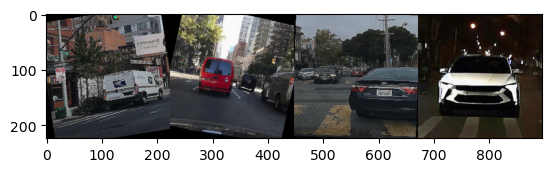

Class labels:  editada real  editada real 


In [409]:
classes = ('real', 'editada')

def imshow(img):
    # unnormalize
    img = transforms.Normalize((0, 0, 0), (1/0.2023, 1/0.1994, 1/0.2010))(img)
    img = transforms.Normalize((-0.4914, -0.4822, -0.4465), (1, 1, 1))(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)

# print images and rotated images
imshow(torchvision.utils.make_grid(images[:4], padding=0))
print('Class labels: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

# Training function

In [410]:
# GPU setting
device = torch.device('cuda')
device

device(type='cuda')

# Model : Resnet 50

In [411]:
import torch

class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        """
        :param patience: 訓練過程中，在驗證損失沒有改善的最大允許輪數
        :param delta: 驗證損失需要改善的最小值（如果增加了 delta，就只有損失改善超過這個值才算有改善）
        """
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False

    def __call__(self, val_loss, model):
        """
        檢查驗證損失是否改善，並決定是否停止訓練。
        
        :param val_loss: 當前 epoch 的驗證損失
        :param model: 用來保存當前最佳模型的 PyTorch 模型
        """
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
            # 保存當前最佳模型
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True


In [412]:
def train_resnet(model, model_name, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    best_val_accuracy = 0.0
    best_val_loss = float('inf')

    # initial EarlyStopping
    early_stopping = EarlyStopping(patience=5, delta=0.001)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Accumulate training statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        # Calculate and store epoch metrics
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)
        train_accuracy = 100 * correct / total
        train_accuracies.append(train_accuracy)

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * correct / total

        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Update learning rate scheduler (check if it's ReduceLROnPlateau)
        if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(val_loss)  # Pass validation loss for ReduceLROnPlateau
        else:
            scheduler.step()  # Step for other schedulers

        # 呼叫 EarlyStopping
        early_stopping(val_loss, model)

        if early_stopping.early_stop:
            print(f"Early stopping at epoch {epoch+1}")
            break  # 停止訓練

        # Print epoch summary
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f"./model/{model_name}.pth")
            print(f"Best model saved! (Epoch {epoch + 1})")

    return train_losses, train_accuracies, val_losses, val_accuracies


In [ ]:
class ResNetModel(nn.Module):
    def __init__(self):
        super(ResNetModel, self).__init__()
        self.model = models.resnet50(weights = 'DEFAULT')
        self.dropout = nn.Dropout(p=0.3)
        # 修改最後的全連接層以適應 2 類輸出
        self.model.fc = nn.Linear(self.model.fc.in_features, 2) 
    def forward(self, x):
        x = self.model(x)
        x = self.dropout(x)
        return x

In [ ]:
from torch.optim.lr_scheduler import CosineAnnealingLR, LinearLR

# (1)
# resnet_model = ResNetModel().to(device)
# criterion = nn.CrossEntropyLoss().to(device)
# optimizer = optim.Adam(resnet_model.parameters(), lr = 1e-4)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
# num_epochs = 20

# (2)
# resnet_model = ResNetModel().to(device)
# criterion = nn.CrossEntropyLoss().to(device)
# optimizer = optim.AdamW(resnet_model.parameters(), lr = 5e-5, weight_decay = 1e-4)
# # 每 5 個 Epoch 將學習率減小 90%，可能過於激進。so,根據驗證 Loss 的停滯自動減小學習率
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)
# num_epochs = 15

# (3)
resnet_model = ResNetModel().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.AdamW(resnet_model.parameters(), lr=5e-5, weight_decay=1e-4)

# 學習率調度器
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=0.8,  # 更平緩的學習率衰減
    patience=5,  # 增加耐心值
    verbose=True
)

num_epochs = 20  # 增加訓練回合數

# (4)   
# resnet_model = ResNetModel().to(device)
# criterion = nn.CrossEntropyLoss().to(device)
# optimizer = optim.Adam(resnet_model.parameters(), lr = 1e-4, betas=(0.5, 0.999))
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
# num_epochs = 15

In [415]:
train_losses, train_accuracies, val_losses, val_accuracies = train_resnet(resnet_model, "resNet", train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs)

Epoch 1/20
Train Loss: 0.6812, Train Accuracy: 56.29%
Val Loss: 0.6675, Val Accuracy: 64.00%
Best model saved! (Epoch 1)


Epoch 2/20
Train Loss: 0.6448, Train Accuracy: 60.81%
Val Loss: 0.6383, Val Accuracy: 73.00%
Best model saved! (Epoch 2)


Epoch 3/20
Train Loss: 0.5951, Train Accuracy: 69.35%
Val Loss: 0.5730, Val Accuracy: 79.00%
Best model saved! (Epoch 3)


Epoch 4/20
Train Loss: 0.4772, Train Accuracy: 80.65%
Val Loss: 0.3564, Val Accuracy: 90.00%
Best model saved! (Epoch 4)


Epoch 5/20
Train Loss: 0.4067, Train Accuracy: 80.16%
Val Loss: 0.2412, Val Accuracy: 93.00%
Best model saved! (Epoch 5)


Epoch 6/20
Train Loss: 0.3077, Train Accuracy: 86.77%
Val Loss: 0.2287, Val Accuracy: 93.00%
Best model saved! (Epoch 6)


Epoch 7/20
Train Loss: 0.2687, Train Accuracy: 87.26%
Val Loss: 0.2319, Val Accuracy: 92.00%


Epoch 8/20
Train Loss: 0.2458, Train Accuracy: 87.58%
Val Loss: 0.2096, Val Accuracy: 92.00%
Best model saved! (Epoch 8)


Epoch 9/20
Train Loss: 0.2543, Train Accuracy: 87.74%
Val Loss: 0.1734, Val Accuracy: 90.00%
Best model saved! (Epoch 9)


Epoch 10/20
Train Loss: 0.2016, Train Accuracy: 91.13%
Val Loss: 0.1515, Val Accuracy: 98.00%
Best model saved! (Epoch 10)


Epoch 11/20
Train Loss: 0.2174, Train Accuracy: 90.97%
Val Loss: 0.2862, Val Accuracy: 91.00%


Epoch 12/20
Train Loss: 0.1865, Train Accuracy: 90.81%
Val Loss: 0.1108, Val Accuracy: 96.00%
Best model saved! (Epoch 12)


Epoch 13/20
Train Loss: 0.2096, Train Accuracy: 89.68%
Val Loss: 0.1537, Val Accuracy: 97.00%


Epoch 14/20
Train Loss: 0.1562, Train Accuracy: 91.77%
Val Loss: 0.1245, Val Accuracy: 94.00%


Epoch 15/20
Train Loss: 0.1712, Train Accuracy: 92.10%
Val Loss: 0.0488, Val Accuracy: 99.00%
Best model saved! (Epoch 15)


Epoch 16/20
Train Loss: 0.1816, Train Accuracy: 90.65%
Val Loss: 0.0700, Val Accuracy: 99.00%


Epoch 17/20
Train Loss: 0.1699, Train Accuracy: 90.32%
Val Loss: 0.0819, Val Accuracy: 98.00%


Epoch 18/20
Train Loss: 0.1239, Train Accuracy: 93.23%
Val Loss: 0.0624, Val Accuracy: 98.00%


Epoch 19/20
Train Loss: 0.1262, Train Accuracy: 94.19%
Val Loss: 0.0874, Val Accuracy: 97.00%


Epoch 20/20
Train Loss: 0.1457, Train Accuracy: 91.94%
Val Loss: 0.0400, Val Accuracy: 100.00%
Best model saved! (Epoch 20)


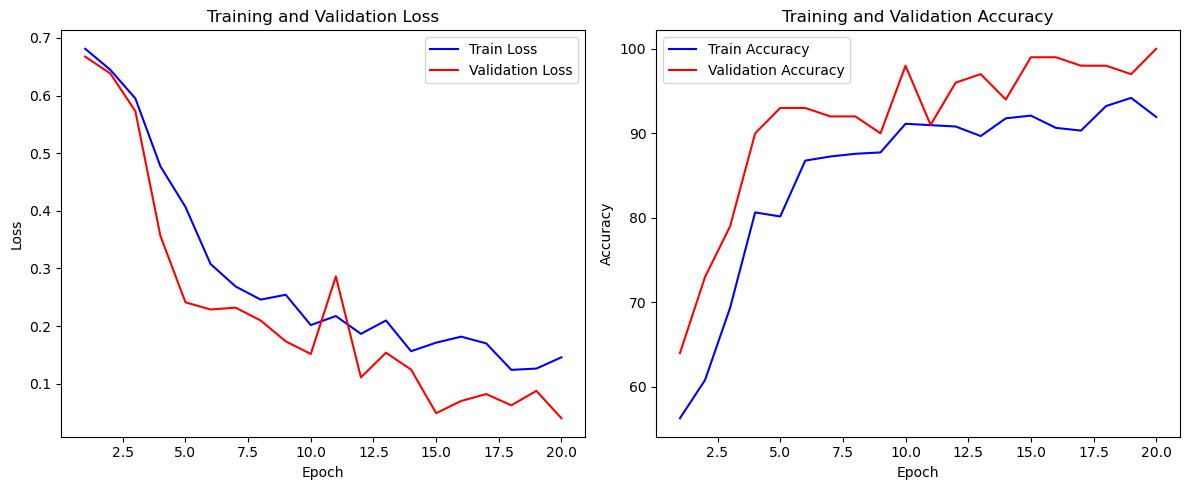

In [416]:
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 5))


# loss圖
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss', color='blue')
plt.plot(epochs, val_losses, label='Validation Loss', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
# acc圖
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy', color='blue')
plt.plot(epochs, val_accuracies, label='Validation Accuracy', color='red')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()

plt.show()

# Test

In [ ]:
# test
test_dir = "./test_data"
test_images = sorted(os.listdir(test_dir))
test_data = []

for img_name in test_images:
    img_path = os.path.join(test_dir, img_name)
    img = Image.open(img_path)
    img = transform_test(img).unsqueeze(0).to(device)

    resnet_model.eval()
    with torch.no_grad():
        output = resnet_model(img)
        _, predicted = torch.max(output.data, 1)
        test_data.append((img_name, predicted.item()))

# 生成csv
submission = pd.DataFrame(test_data, columns=["image", "label"])
submission.to_csv(f"./submission/resnet_model2.csv", index=False)

print("Submission file created!")

Submission file created!


: 